# Basic workflow with ART for evasion attacks and defenses

In [1]:
%matplotlib inline
import keras.backend as k
from keras.applications import vgg16
from keras.preprocessing import image
from keras.utils import np_utils
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

Using TensorFlow backend.


## Import a standard visual recognition model

Here, we will use Keras as backend and ImageNet as dataset. We load the standard ResNet50 model from Keras.

In [2]:
# Load model
from keras.applications.resnet50 import ResNet50, preprocess_input
from art.classifiers import KerasClassifier

# Load model
mean_imagenet = np.zeros([224, 224,3])
mean_imagenet[...,0].fill(103.939)
mean_imagenet[...,1].fill(116.779)
mean_imagenet[...,2].fill(123.68)
model = ResNet50(weights='imagenet')
classifier = KerasClassifier(clip_values=(0, 255), model=model, preprocessing=(mean_imagenet,1))

Load an ImageNet example image. You can replace this with your own images.

Prediction: trench coat - confidence 1.00


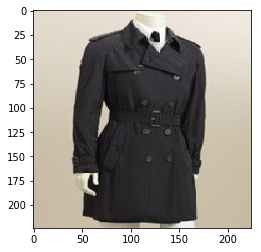

In [3]:
from os.path import join, abspath, expanduser

# Get Imagenet labels
path = expanduser('~/git/nemesis')
with open(join(path, "imagenet/labels.txt"), "r") as f_input:
    class_names = eval(f_input.read())

# Get some data
image_file = join(path,'test_api/clean100/n04479046_2998_224x224.jpg')
image_ = image.load_img(image_file, target_size=(224, 224))
img = image.img_to_array(image_)
plt.imshow(img / 255)
img = img[None, ...]

# Predict for clean image
pred = classifier.predict(img)
label = np.argmax(pred, axis=1)[0]
confidence = pred[:,label][0]
print('Prediction:', class_names[label], '- confidence {0:.2f}'.format(confidence))

## Perform evasion attack

Prediction: military uniform - confidence 0.98


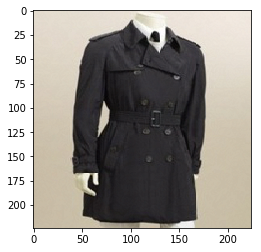

In [4]:
from art.attacks import ProjectedGradientDescent

# Create attacker
adv = ProjectedGradientDescent(classifier, targeted=False, eps_step=1, eps=4, max_iter=1)

# Generate attack image
img_adv = adv.generate(img)

# Evaluate it on model
pred_adv = model.predict(img_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', class_names[label_adv], '- confidence {0:.2f}'.format(confidence_adv))
plt.imshow(img_adv[0] / 255)

## Compute attack statistics

We can measure the quantity of noise that was introduced to the image by the attack under different $L_p$ norms. Notive that the projected gradient descent attacks optimizes the $L_0$ norm.

Noise L_0 norm: 99%
Noise L_2 norm: 1%
Noise L_inf norm: 1%


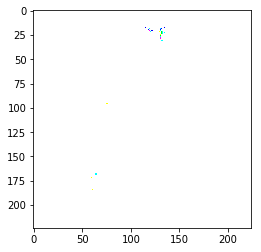

In [5]:
import numpy as np

l0 = int(99*len(np.where(np.abs(img[0] - img_adv[0])>0.5)[0]) / (224*224*3)) + 1   
l1 = int(99*np.sum(np.abs(img[0] - img_adv[0])) / np.sum(np.abs(img[0]))) + 1
l2 = int(99*np.linalg.norm(img[0] - img_adv[0]) / np.linalg.norm(img[0])) + 1 
linf = int(99*np.max(np.abs(img[0] - img_adv[0])) / 255) + 1
print('Noise L_0 norm: %d%%' % l0)
print('Noise L_2 norm: %d%%' % l2)
print('Noise L_inf norm: %d%%' % linf)
plt.imshow(np.abs(img[0] - img_adv[0]))

## Apply defense

We apply feature squeezing as defense before putting the attack image into the classification model. This defense reduces the colour depth of the image. Here, each colour channel will be encoded on 4 bits (`bit_depth=4`). Notice that the prediction is now correct again, albeit with lower confidence value than on the clean image.

Prediction: trench coat - confidence 0.60


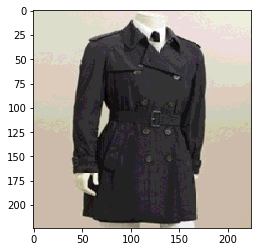

In [6]:
from art.defences import FeatureSqueezing

fs = FeatureSqueezing(bit_depth=4, clip_values=(0, 255))
img_def = fs(img_adv)
pred_def = model.predict(img_def)
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]
print('Prediction:', class_names[label_def], '- confidence {0:.2f}'.format(confidence_def))
plt.imshow(img_def[0] / 255)